<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

# **Longitudinal Prediction**

Can we use previous year's data and compoundingly predict suicide risk?

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

In [297]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import re

In [298]:
import warnings
warnings.filterwarnings("ignore")

___________

### **Helper Functions**

In [299]:
def get_yearly_columns(base_cols, years):
    return [f"{col}{year}" for col in base_cols for year in years]

In [300]:
def get_encoded_columns(df, variables):
    cols = []
    for var in variables:
        cs = df.filter(regex=fr"^{var}.+").columns.tolist()
        unique_cs = set()
        for c in cs:
            match = re.search(r"(.+)(\d{4})", c)
            if match:
                c_name, _ = match.groups()
                unique_cs.add(c_name)
        cols += list(unique_cs)
    return cols

___________

### **Data**

In [301]:
cohorts = range(2023, 2027)
years = range(2020, 2024)

In [302]:
# Read formatted linked persons
final23 = pd.read_csv("processed/final23.csv")
final24 = pd.read_csv("processed/final24.csv")
final25 = pd.read_csv("processed/final25.csv")
final26 = pd.read_csv("processed/final26.csv")
all_linked = pd.concat([final23, final24, final25, final26], ignore_index=True, axis=0)

final = {
    2023: final23,
    2024: final24,
    2025: final25,
    2026: final26,
}

In [307]:
# Read encoded linked persons
encoded23 = pd.read_csv("encoded/encoded23.csv")
encoded24 = pd.read_csv("encoded/encoded24.csv")
encoded25 = pd.read_csv("encoded/encoded25.csv")
encoded26 = pd.read_csv("encoded/encoded26.csv")

________

In [ ]:
# Questions sorted by categorical, ordinal, and quantitative

ordinal_cols = {
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
}

quant_cols = {
    "INV.DBL.APSS.Total",
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Total",
}

cat_cols = {
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.White",
    "SBJ.LGL.Race.Multiple",
}

In [281]:
# All common questions across years

# Survey
survey = [
    "Unnamed: 0",
    "IDX.INT.Origin.Database",
    "IDX.INT.Origin.Record",
    "SSS.INT.SurveyYear",
    "IDX.INT.Row",
    "IDX.CHR.Linked.ID",
    "QCC.LGC.Linked.Attempted",
    "QCC.LGC.Linked",
    "QCC.LGC.Linked.No_issues",
    "QCC.CHR.Linked.Score.Base",
    "QCC.CHR.Linked.Score.Add",
    "QCC.CHR.Linked.Rows",
    "QCC.CHR.Linked.Dissimilarity",
]
   
# Adolescent Psychotic-like Symptoms 
psychotic = [
    "INV.DBL.APSS.Q1.MindReading",
    "INV.DBL.APSS.Q2.TVRadio",
    "INV.DBL.APSS.Q3.Spying",
    "INV.DBL.APSS.Q4.Auditory",
    "INV.DBL.APSS.Q5.Controlled",
    "INV.DBL.APSS.Q6.Visual",
    "INV.DBL.APSS.Q7.Grandiosity",
    "INV.DBL.APSS.Total",
]
    
# Emotional Reactivity 
emotional = [
    "INV.INT.ERS.IntensityArousalTotal",
    "INV.INT.ERS.PersistenceTotal",
    "INV.INT.ERS.Q01.Persistence1",
    "INV.INT.ERS.Q02.Sensitivity1",
    "INV.INT.ERS.Q03.IntensityArousal1",
    "INV.INT.ERS.Q04.IntensityArousal2",
    "INV.INT.ERS.Q05.Sensitivity2",
    "INV.INT.ERS.Q06.IntensityArousal3",
    "INV.INT.ERS.Q07.Sensitivity3",
    "INV.INT.ERS.Q08.Persistence2",
    "INV.INT.ERS.Q09.Sensitivity4",
    "INV.INT.ERS.Q10.Persistence3",
    "INV.INT.ERS.Q11.Persistence4",
    "INV.INT.ERS.Q12.Sensitivity5",
    "INV.INT.ERS.Q13.Sensitivity6",
    "INV.INT.ERS.Q14.Sensitivity7",
    "INV.INT.ERS.Q15.Sensitivity8",
    "INV.INT.ERS.Q16.Sensitivity9",
    "INV.INT.ERS.Q17.IntensityArousal4",
    "INV.INT.ERS.Q18.Sensitivity10",
    "INV.INT.ERS.Q19.IntensityArousal5",
    "INV.INT.ERS.Q20.IntensityArousal6",
    "INV.INT.ERS.Q21.IntensityArousal7",
    "INV.INT.ERS.SensitivityTotal",
    "INV.INT.ERS.Total",
]
    
# PHQ4
phq4 = [
    "INV.INT.PHQ4.Anxiety",
    "INV.INT.PHQ4.Depression",
    "INV.INT.PHQ4.Q1.Anxious",
    "INV.INT.PHQ4.Q2.Worried",
    "INV.INT.PHQ4.Q3.Depressed",
    "INV.INT.PHQ4.Q4.Anhedonia",
    "INV.INT.PHQ4.Total",
    "INV.LGL.PHQ4.Anxiety",
    "INV.LGL.PHQ4.Depression",
    # "INV.FCT.PHQ4.Total",
]
    
# Suicidality
suicide = [
    "INV.INT.SI.Attempt",
    "INV.INT.SI.How",
    "INV.INT.SI.Selfharm",
    "INV.INT.SI.Thoughts",
]
    
# Substance Use
substance = [
    "INV.INT.SUB.Alcohol.Past30",
    "INV.INT.SUB.Cannabis.Past30",
    "INV.INT.SUB.Cigarettes.Past30",
    "INV.INT.SUB.Cigars.Past30",
    "INV.INT.SUB.Smokeless.Past30",
    "INV.INT.SUB.Vapes.Past30",
    
    "INV.LGL.SUB.Alcohol.Life",
    "INV.LGL.SUB.Cannabis.Life",
    "INV.LGL.SUB.Cigarettes.Life",
    "INV.LGL.SUB.Cigars.Life",
    "INV.LGL.SUB.Smokeless.Life",
    "INV.LGL.SUB.Vapes.Life",
]
    
# Help Seeking
help = [
    "INV.LGL.HelpSeeking0",
    "INV.LGL.HelpSeeking1",
    "INV.LGL.HelpSeeking2",
    "INV.LGL.HelpSeeking3",
    "INV.LGL.HelpSeeking4",
    "INV.LGL.HelpSeeking5",
    "INV.LGL.HelpSeeking6",
    "INV.LGL.HelpSeeking7",
    "INV.LGL.HelpSeeking8",
    "INV.LGL.HelpSeeking9",
    "INV.LGL.HelpSeeking10",
    "INV.LGL.HelpSeeking11",
    "INV.LGL.HelpSeeking12",
    "INV.LGL.HelpSeeking13",
    # "INV.CHR.HelpSeeking.Other",
]
    
# Identity
identity = [
    # "SBJ.CHR.Gender.Other",
    # "SBJ.CHR.Link.Streetname",
    # "SBJ.CHR.SexualOrientation.Other",
    "SBJ.FCT.Ethnicity",
    "SBJ.FCT.GenderId",
    # "SBJ.FCT.Link.BirthMonth",
    # "SBJ.FCT.Link.EyeColor",
    # "SBJ.FCT.Link.MiddleInitial",
    # "SBJ.FCT.Link.OlderSiblings",
    # "SBJ.FCT.Race",
    "SBJ.FCT.Sex",
    "SBJ.FCT.Sexuality",
    # "SBJ.INT.Link.KindergartenYearEst",
    "SBJ.LGL.Race.AmericanIndianAlaskaNative",
    "SBJ.LGL.Race.Asian",
    "SBJ.LGL.Race.HaitianBlackAfricanAmerican",
    "SBJ.LGL.Race.HawaiianPacificIslander",
    "SBJ.LGL.Race.MiddleEasternNorthAfrican",
    "SBJ.LGL.Race.Multiple",
    # "SBJ.LGL.Race.Other",
    "SBJ.LGL.Race.White",
]
    
# School
school = [
    "SSS.CHR.GradesSurveyed",
    "SSS.DBL.PercentOptOutsbyGrades",
    "SSS.DBL.PercentOptOutsbySchool",
    "SSS.INT.Cohort",
    "SSS.INT.District.Code",
    "SSS.INT.Eighth.Grade.Enrollment",
    "SSS.INT.Eleventh.Grade.Enrollment",
    "SSS.INT.Fifth.Grade.Enrollment",
    "SSS.INT.Grade",
    "SSS.INT.Ninth.Grade.Enrollment",
    "SSS.INT.School.Code",
    "SSS.INT.Seventh.Grade.Enrollment",
    "SSS.INT.Sixth.Grade.Enrollment",
    "SSS.INT.Tenth.Grade.Enrollment",
    "SSS.INT.Time_point",
    "SSS.INT.Twelfth.Grade.Enrollment",
]

all_qs = psychotic + help + suicide + school + identity + substance + phq4

In [308]:
psychotic_e = get_encoded_columns(encoded23, psychotic)
emotional_e = get_encoded_columns(encoded23, emotional)
phq4_e = get_encoded_columns(encoded23, phq4)
suicide_e = get_encoded_columns(encoded23, suicide)
substance_e = get_encoded_columns(encoded23, substance)
help_e = get_encoded_columns(encoded23, help)
identity_e = get_encoded_columns(encoded23, identity)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Rational**

What variables are actually important/have significance in our prediction model?

In [169]:
def plot_conditioned_vars(df, explore_qs, condition_q):
    filtered_df = df[df[condition_q] != -1]
    
    num_plots = len(explore_qs)
    num_cols = 4
    num_rows = math.ceil(num_plots / num_cols) 

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows)) 
    axes = axes.flatten()

    for i, explore_q in enumerate(explore_qs):
        if explore_q == condition_q:
            continue
        
        filtered_df = filtered_df[filtered_df[explore_q] != -1]
        
        num_categories = len(set(filtered_df[explore_q]))
        if num_categories <= 3:
            count_df = filtered_df.groupby([condition_q, explore_q]).size().reset_index(name="Count")
            count_df["Proportion"] = count_df.groupby(condition_q)["Count"].transform(lambda x: x / x.sum())
            
            sns.barplot(
                x=condition_q, y="Proportion", hue=explore_q,
                data=count_df, palette=["lightcoral", "lightblue"], ax=axes[i]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(condition_q, fontsize=12)
            axes[i].set_ylabel("Proportion", fontsize=12)
            axes[i].set_ylim((0, 1))
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title=explore_q)
        else:
            sns.histplot(
                data=filtered_df, x=explore_q, hue=condition_q, bins=num_categories, kde=True, 
                stat="density", element="step", common_norm=False, ax=axes[i], palette=["lightcoral", "lightblue"]
            )
            axes[i].set_title(f"{explore_q}", fontsize=14)
            axes[i].set_xlabel(explore_q, fontsize=12)
            axes[i].set_ylabel("Frequency", fontsize=12)
            axes[i].legend(title=condition_q)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout() 
    plt.show()

In [ ]:
"""
Uncomment the following code to distributions of variables conditioning on a specific suicidality question!
"""
# question = "Selfharm"
# category = suicide

# plot_conditioned_vars(final23, get_yearly_columns(category, [2023]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2023")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2022]), f"INV.INT.SI.{question}2022")
# plot_conditioned_vars(final23, get_yearly_columns(category, [2021]), f"INV.INT.SI.{question}2022")

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

## **Fine-Tuning Final Models**

We are looking into the top models for each suicidality question.

In [208]:
# top models:
attempt_mods = ["XGBoost", "RandomForest", "LDA", "Logistic"]
how_mods = ["XGBoost", "RandomForest", "LDA", "Logistic"]
thoughts_mods = ["LDA", "LightGBM", "RandomForest", "Logistic"]
selfharm_mods = ["NeuralNet", "SupportVector", "CatBoost", "Logistic"]

outcome_models = {
    "Attempt": attempt_mods,
    "How": how_mods,
    "Thoughts": thoughts_mods,
    "Selfharm": selfharm_mods,
}

_______

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import PolynomialFeatures

# models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [210]:
models = {
    "Logistic": (
        LogisticRegression(random_state=42), 
        {
            'C': np.logspace(-4,4,20),
            "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
            "solver": ['liblinear', 'lbfgs', 'newton-cg', ], 
        }
    ),
    "XGBoost": (
        XGBClassifier(eval_metric='auc'),
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42), 
        {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
    ),
    "LDA": (
        LinearDiscriminantAnalysis(), 
        {'solver': ['svd', 'lsqr', 'eigen']}
    ),
    "LightGBM": (
        LGBMClassifier(), 
        {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
    ),
    "CatBoost": (
        CatBoostClassifier(verbose=0), 
        {'iterations': [50, 100], 'depth': [4, 6]}
    ),
    "NeuralNet": (
        MLPClassifier(max_iter=500), 
        {'hidden_layer_sizes': [(50,), (100,)], 'max_iter': [300, 500]}
    ),
    "SupportVector": (
        SVC(probability=True), 
        {'C': [0.1, 1, 10]}
    )
}

In [ ]:
def train_models(df, outcome, pred_year, interactions=False):
    print(f"Fine-tuning models for {outcome}")
    
    feature_cols = [*get_yearly_columns(suicide_e, [pred_year]),
                    *get_yearly_columns(psychotic_e, [pred_year]), 
                    *get_yearly_columns(phq4_e, [pred_year]), 
                    *get_yearly_columns(substance_e, [pred_year]), 
                    *get_yearly_columns(identity_e, [pred_year]), 
                    *get_yearly_columns(help_e, [pred_year])]
    target_col= f"INV.INT.SI.{outcome}_1.0{pred_year + 1}"

    df = df.replace("missing", -1).fillna(-1)
    df = df[df[target_col] != -1]

    X, y = df[feature_cols], df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    outcome_results = []
    
    if interactions:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_train_array = poly.fit_transform(X_train)
        X_test_array = poly.transform(X_test)

        X_train = pd.DataFrame(X_train_array, columns=poly.get_feature_names_out(feature_cols))
        X_test = pd.DataFrame(X_test_array, columns=poly.get_feature_names_out(feature_cols))

    final_probs = X_test.copy() 
    final_probs[outcome] = y_test.values

    plt.figure(figsize=(10, 8))
    # Tune models
    for mod_name in outcome_models[outcome]:
        print(f"Tuning {mod_name} for {outcome}!")

        mod, param_grid = models[mod_name]
        grid_search = GridSearchCV(mod, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        
        # Classification
        y_pred = best_model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, target_names=["no", "yes"], output_dict=True)
        
        # Probabilities
        y_pred_proba = best_model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        final_probs[f"probs{mod_name}"] = y_pred_proba

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f"{mod_name} (AUC = {auc_score:.3f})")

        outcome_results.append({
            "Model": mod_name,
            "Best Params": grid_search.best_params_,
            "Accuracy": accuracy,
            "ROC AUC": auc_score,
            "Precision": report["yes"]["precision"],
            "Recall": report["yes"]["recall"],
            "F1": report["yes"]["f1-score"],
        })

        print(f"{mod_name} - Best Params: {grid_search.best_params_}, AUC: {auc_score:.3f}")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray') 
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves for {outcome} Models")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return pd.DataFrame(outcome_results), final_probs


<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>

In [322]:
attempt_results, attempt_final_probs = train_models(encoded23, "Attempt", 2022)
display(attempt_results)

Fine-tuning models for Attempt
Tuning XGBoost for Attempt!


ValueError: 
All the 20 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/sklearn.py", line 1580, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/sklearn.py", line 603, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/sklearn.py", line 1065, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 1573, in __init__
    self._init(
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 1632, in _init
    it.reraise()
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 569, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 550, in _handle_exception
    return fn()
           ^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 637, in <lambda>
    return self._handle_exception(lambda: self.next(input_data), 0)
                                          ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/data.py", line 1402, in next
    input_data(**self.kwargs)
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/core.py", line 617, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/data.py", line 1447, in _proxy_transform
    df, feature_names, feature_types = _transform_pandas_df(
                                       ^^^^^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/data.py", line 611, in _transform_pandas_df
    arrays = pandas_transform_data(data)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/data.py", line 550, in pandas_transform_data
    result.append(oth_type(data[col]))
                  ^^^^^^^^^^^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/xgboost/data.py", line 515, in oth_type
    ser.dtype,
    ^^^^^^^^^
  File "/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/pandas/core/generic.py", line 6299, in __getattr__
    return object.__getattribute__(self, name)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'DataFrame' object has no attribute 'dtype'. Did you mean: 'dtypes'?


<Figure size 1000x800 with 0 Axes>

Fine-tuning models for How
Tuning XGBoost for How!
XGBoost - Best Params: {'learning_rate': 0.01, 'n_estimators': 100}, AUC: 0.611
Tuning RandomForest for How!
RandomForest - Best Params: {'max_depth': 10, 'n_estimators': 50}, AUC: 0.604
Tuning LDA for How!
LDA - Best Params: {'solver': 'svd'}, AUC: 0.603
Tuning Logistic for How!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}, AUC: 0.590


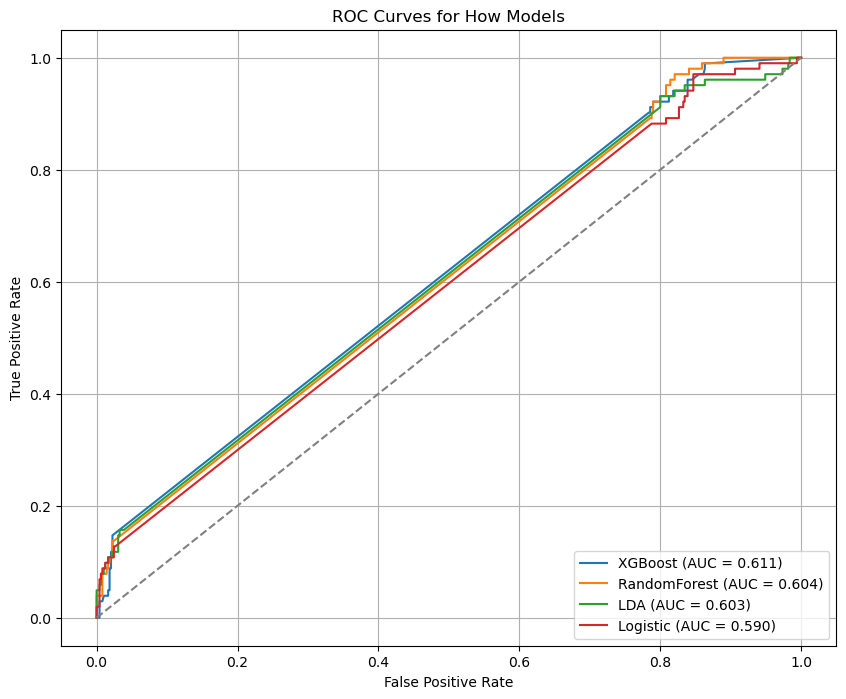

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,XGBoost,"{'learning_rate': 0.01, 'n_estimators': 100}",0.824324,0.611084,0.000000,0.000000,0.000000
1,RandomForest,"{'max_depth': 10, 'n_estimators': 50}",0.834459,0.604412,1.000000,0.039216,0.075472
2,LDA,{'solver': 'svd'},0.832770,0.602931,0.714286,0.049020,0.091743
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l1', 's...",0.831081,0.590086,1.000000,0.019608,0.038462


In [63]:
how_results, how_final_probs = train_models(final23, "How", 2022)
display(how_results)

Fine-tuning models for Thoughts
Tuning LDA for Thoughts!
LDA - Best Params: {'solver': 'svd'}, AUC: 0.590
Tuning LightGBM for Thoughts!
[LightGBM] [Info] Number of positive: 338, number of negative: 1556
[LightGBM] [Info] Number of positive: 338, number of negative: 1556
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Info] Number of positive: 338, number of negative: 1557
[LightGBM] [Info] Number of positive: 338, number of negative: 1557
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005557 seconds.
You can set `force_col_wise=true` to remove the overhe

/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}, AUC: 0.568


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


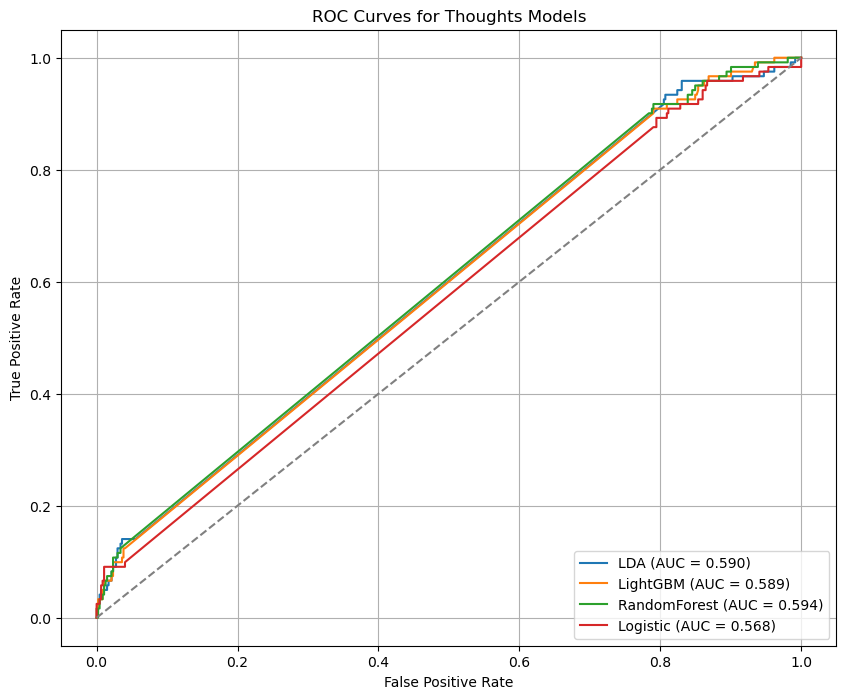

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,LDA,{'solver': 'svd'},0.792580,0.589981,0.444444,0.066116,0.115108
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 100}",0.797639,0.589106,0.666667,0.016529,0.032258
2,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",0.797639,0.594464,0.600000,0.024793,0.047619
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l1', 's...",0.799325,0.567832,0.666667,0.033058,0.062992


In [64]:
thoughts_results, thoughts_final_probs = train_models(final23, "Thoughts", 2022)
display(thoughts_results)

Fine-tuning models for Selfharm
Tuning NeuralNet for Selfharm!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


NeuralNet - Best Params: {'hidden_layer_sizes': (100,), 'max_iter': 500}, AUC: 0.578
Tuning SupportVector for Selfharm!
SupportVector - Best Params: {'C': 1}, AUC: 0.590
Tuning CatBoost for Selfharm!
CatBoost - Best Params: {'depth': 4, 'iterations': 100}, AUC: 0.555
Tuning Logistic for Selfharm!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.23357214690901212, 'penalty': 'l2', 'solver': 'newton-cg'}, AUC: 0.573


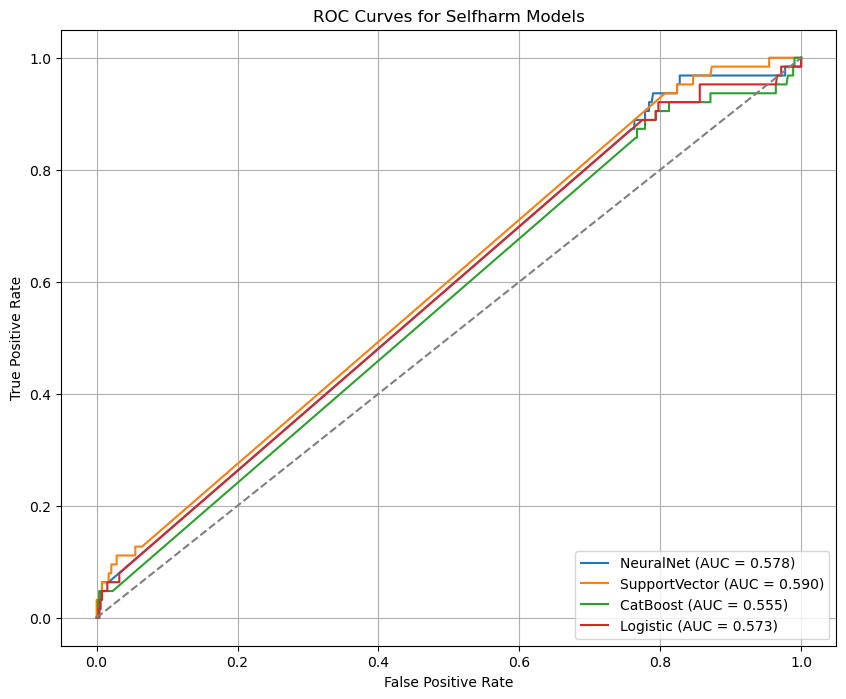

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,NeuralNet,"{'hidden_layer_sizes': (100,), 'max_iter': 500}",0.891709,0.578328,0.4,0.031746,0.058824
1,SupportVector,{'C': 1},0.895093,0.589752,1.0,0.015873,0.031250
2,CatBoost,"{'depth': 4, 'iterations': 100}",0.893401,0.554849,0.5,0.031746,0.059701
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l2', 's...",0.890017,0.573368,0.0,0.000000,0.000000


In [65]:
selfharm_results, selfharm_final_probs = train_models(final23, "Selfharm", 2022)
display(selfharm_results)

________

### **Interaction Terms**

Fine-tuning models for Attempt
Tuning XGBoost for Attempt!
XGBoost - Best Params: {'learning_rate': 0.01, 'n_estimators': 100}, AUC: 0.549
Tuning RandomForest for Attempt!
RandomForest - Best Params: {'max_depth': 10, 'n_estimators': 200}, AUC: 0.557
Tuning LDA for Attempt!
LDA - Best Params: {'solver': 'svd'}, AUC: 0.577
Tuning Logistic for Attempt!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.615848211066026, 'penalty': 'l2', 'solver': 'newton-cg'}, AUC: 0.565


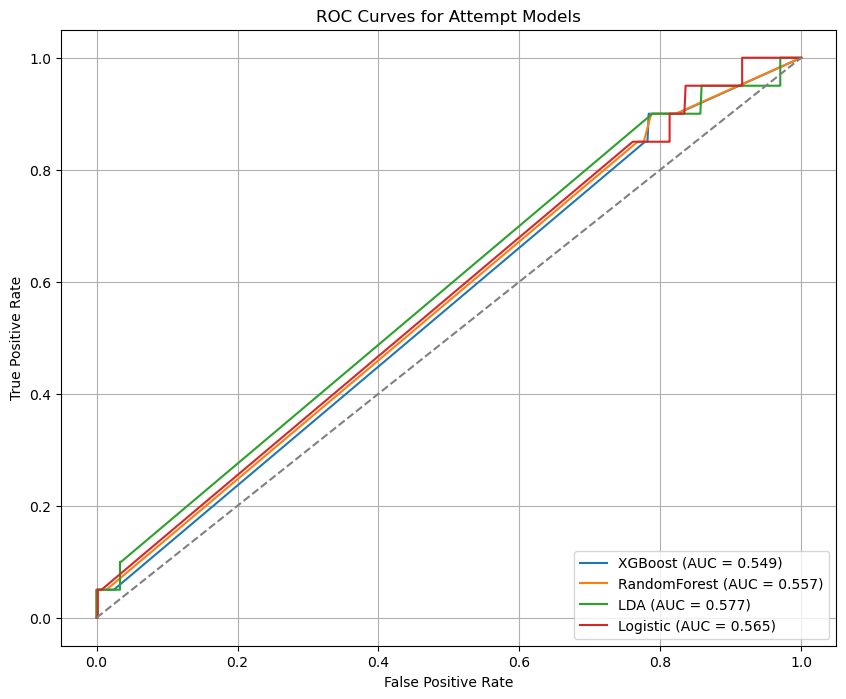

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,XGBoost,"{'learning_rate': 0.1, 'n_estimators': 50}",0.967960,0.607068,1.000000,0.05,0.095238
1,RandomForest,"{'max_depth': 20, 'n_estimators': 200}",0.967960,0.558464,1.000000,0.05,0.095238
2,LDA,{'solver': 'svd'},0.962901,0.575785,0.333333,0.10,0.153846
3,Logistic,"{'C': 4.281332398719396, 'penalty': 'l2', 'sol...",0.967960,0.601963,1.000000,0.05,0.095238


In [ ]:
attempt_poly_results, attempt_poly_final_probs = train_models(final23, "Attempt", 2022, interactions=True)
display(attempt_results)

In [71]:
attempt_poly_results

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,XGBoost,"{'learning_rate': 0.01, 'n_estimators': 100}",0.966273,0.548560,0.000000,0.00,0.000000
1,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",0.967960,0.557068,1.000000,0.05,0.095238
2,LDA,{'solver': 'svd'},0.959528,0.577443,0.166667,0.05,0.076923
3,Logistic,"{'C': 0.615848211066026, 'penalty': 'l2', 'sol...",0.964587,0.564529,0.333333,0.05,0.086957


Fine-tuning models for How
Tuning XGBoost for How!
XGBoost - Best Params: {'learning_rate': 0.01, 'n_estimators': 100}, AUC: 0.580
Tuning RandomForest for How!
RandomForest - Best Params: {'max_depth': 10, 'n_estimators': 200}, AUC: 0.612
Tuning LDA for How!
LDA - Best Params: {'solver': 'svd'}, AUC: 0.531
Tuning Logistic for How!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}, AUC: 0.570


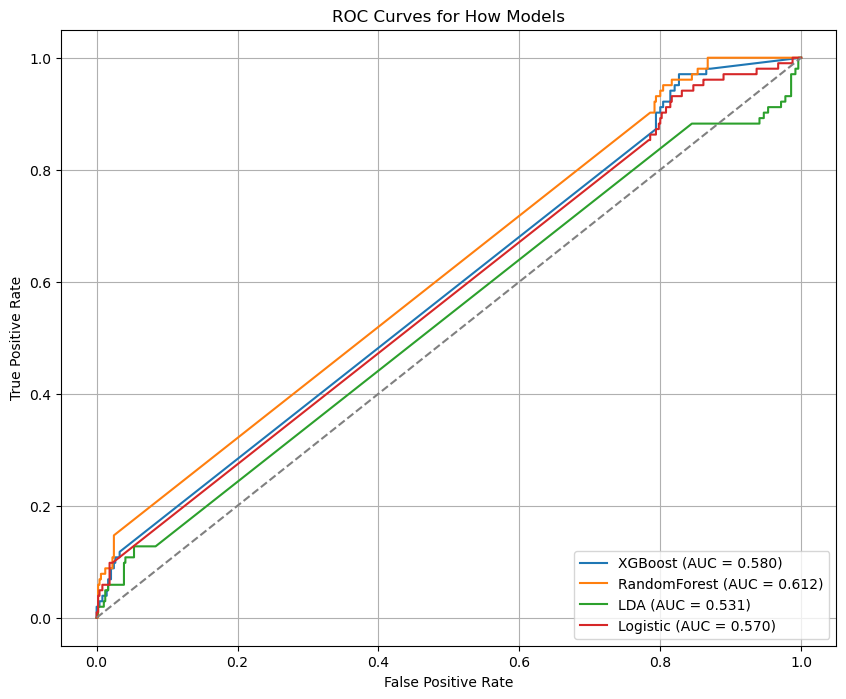

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,XGBoost,"{'learning_rate': 0.01, 'n_estimators': 100}",0.824324,0.611084,0.000000,0.000000,0.000000
1,RandomForest,"{'max_depth': 10, 'n_estimators': 50}",0.834459,0.604412,1.000000,0.039216,0.075472
2,LDA,{'solver': 'svd'},0.832770,0.602931,0.714286,0.049020,0.091743
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l1', 's...",0.831081,0.590086,1.000000,0.019608,0.038462


,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,XGBoost,"{'learning_rate': 0.01, 'n_estimators': 100}",0.829392,0.580102,1.000000,0.009804,0.019417
1,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",0.829392,0.611755,0.666667,0.019608,0.038095
2,LDA,{'solver': 'svd'},0.793919,0.531152,0.282609,0.127451,0.175676
3,Logistic,"{'C': 0.08858667904100823, 'penalty': 'l1', 's...",0.831081,0.569938,0.625000,0.049020,0.090909


In [72]:
how_poly_results, how_poly_final_probs = train_models(final23, "How", 2022, interactions=True)
display(how_results)
display(how_poly_results)

Fine-tuning models for Thoughts
Tuning LDA for Thoughts!
LDA - Best Params: {'solver': 'svd'}, AUC: 0.503
Tuning LightGBM for Thoughts!
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 338, number of negative: 1557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 338, number of negative: 1556
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 337, number of negative: 1557
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 338, number of negative: 1557
[LightGBM] [Info] Number of positive: 337, n

/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}, AUC: 0.579


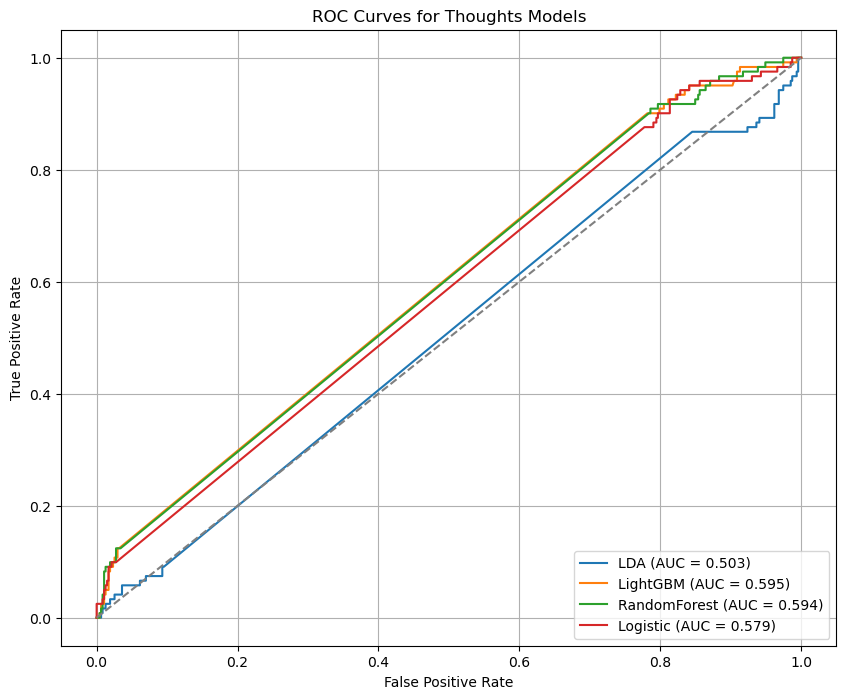

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,LDA,{'solver': 'svd'},0.792580,0.589981,0.444444,0.066116,0.115108
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 100}",0.797639,0.589106,0.666667,0.016529,0.032258
2,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",0.797639,0.594464,0.600000,0.024793,0.047619
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l1', 's...",0.799325,0.567832,0.666667,0.033058,0.062992


,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,LDA,{'solver': 'svd'},0.755481,0.502539,0.214286,0.074380,0.110429
1,LightGBM,"{'learning_rate': 0.01, 'n_estimators': 50}",0.795953,0.595050,0.000000,0.000000,0.000000
2,RandomForest,"{'max_depth': 10, 'n_estimators': 200}",0.794266,0.593553,0.428571,0.024793,0.046875
3,Logistic,"{'C': 0.08858667904100823, 'penalty': 'l1', 's...",0.795953,0.578915,0.500000,0.033058,0.062016


In [73]:
thoughts_poly_results, thoughts_poly_final_probs = train_models(final23, "Thoughts", 2022, interactions=True)
display(thoughts_results)
display(thoughts_poly_results)

Fine-tuning models for Selfharm
Tuning NeuralNet for Selfharm!
NeuralNet - Best Params: {'hidden_layer_sizes': (50,), 'max_iter': 300}, AUC: 0.539
Tuning SupportVector for Selfharm!
SupportVector - Best Params: {'C': 10}, AUC: 0.585
Tuning CatBoost for Selfharm!
CatBoost - Best Params: {'depth': 4, 'iterations': 100}, AUC: 0.570
Tuning Logistic for Selfharm!


/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/weili/micromamba/envs/cs109a/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/lin

Logistic - Best Params: {'C': 0.004832930238571752, 'penalty': 'l2', 'solver': 'lbfgs'}, AUC: 0.564


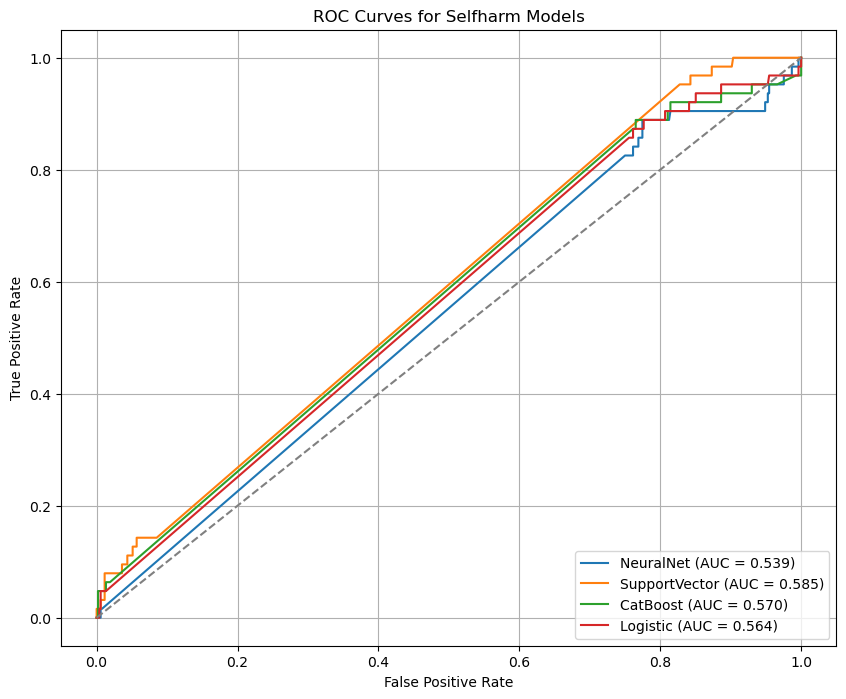

,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,NeuralNet,"{'hidden_layer_sizes': (100,), 'max_iter': 500}",0.891709,0.578328,0.4,0.031746,0.058824
1,SupportVector,{'C': 1},0.895093,0.589752,1.0,0.015873,0.031250
2,CatBoost,"{'depth': 4, 'iterations': 100}",0.893401,0.554849,0.5,0.031746,0.059701
3,Logistic,"{'C': 0.23357214690901212, 'penalty': 'l2', 's...",0.890017,0.573368,0.0,0.000000,0.000000


,Model,Best Params,Accuracy,ROC AUC,Precision,Recall,F1
0,NeuralNet,"{'hidden_layer_sizes': (50,), 'max_iter': 300}",0.890017,0.539187,0.25,0.015873,0.029851
1,SupportVector,{'C': 10},0.893401,0.585332,0.50,0.015873,0.030769
2,CatBoost,"{'depth': 4, 'iterations': 100}",0.891709,0.569805,0.00,0.000000,0.000000
3,Logistic,"{'C': 0.004832930238571752, 'penalty': 'l2', '...",0.890017,0.563567,0.00,0.000000,0.000000


In [74]:
selfharm_poly_results, selfharm_poly_final_probs = train_models(final23, "Selfharm", 2022, interactions=True)
display(selfharm_results)
display(selfharm_poly_results)

______

### **Comparing ML vs. Parametric (Logistic)**

End of notebook :)

<div style="background-color: #007BFF; height: 4px; width: 100%;"></div>